In [1]:
from tensorflow.keras.applications.vgg19 import preprocess_input,decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import models
#conv5/conv5_2 unit 148
#VGG 19
#Data from https://github.com/fastai/imagenette?tab=readme-ov-file
vgg = tf.keras.applications.VGG19()
#https://www.kaggle.com/datasets/deeptrial/miniimagenet


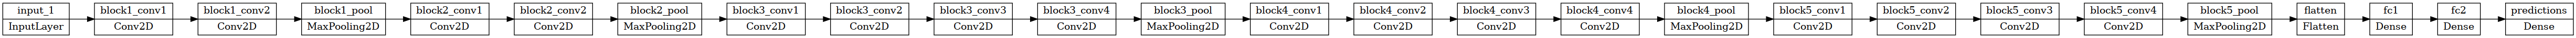

In [2]:
tf.keras.utils.plot_model(vgg,rankdir='LR')

In [3]:
IMG_SHAPE = (224,224)

# Image Processing

In [4]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

In [5]:
def clean_image_directory(filepath): #Will remove greyscale images from directory
    data = {}
    for subfolder in os.listdir(filepath):
        data[subfolder] = 0
        subfolder_path = os.path.join(filepath,subfolder)
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path,img_name)
            img = Image.open(img_path)
            if img.mode == "L":
                print(f'Removed {img_path}')
                os.remove(img_path)
            else:
                data[subfolder] = data[subfolder] + 1
    # print(data)
    # print(min(data.values()))

clean_image_directory('./ImageNet-Mini/images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


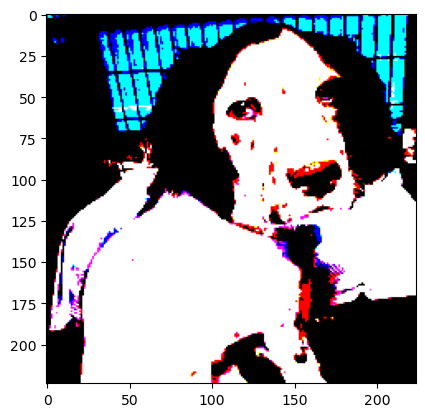

In [6]:
def load_image_for_processing(filepath,prep_for_vgg=True):
    img = Image.open(filepath)
    img = img.resize(size=IMG_SHAPE) #reisze to model's input expectation (can change model input and this still works)
    img = np.array(img)
    if prep_for_vgg:
        img = preprocess_input(img)
    return img



plt.imshow(load_image_for_processing('/mnt/c/Users/alexs/ML/Proj3/ML_Conv_Visuals/imagenette2-320/train/n02102040/ILSVRC2012_val_00016833.JPEG',prep_for_vgg=True))

In [7]:
import json
import pprint
pp = pprint.PrettyPrinter(indent=3)
def get_name_mapper(filepath):
    with open(filepath,'r') as fp:
        dct = json.load(fp)
        # pp.pprint(dct)
        _dct = {}
        for val in dct.values():
            _dct[val[0]] = val[1]
    return _dct
            

In [8]:
def get_example_images(directory_path,num_classes=2,num_examples_per_class=2,prep_for_vgg=False,name_mapper_filepath='ImageNet-Mini/imagenet_class_index.json'):
    possible_classes = os.listdir(directory_path)
    num_classes = min(len(possible_classes),num_classes)
    chosen_classes = np.random.choice(possible_classes,size=num_classes,replace=False)
    print(f'Classes Chosen: {chosen_classes}')
    data = {}
    mapper = get_name_mapper(name_mapper_filepath)

    for cls in chosen_classes:
        mapped_class = mapper.get(cls,None)
        if mapped_class is None:
            raise RuntimeError(f'Could not look up class {cls}')
        data[mapped_class] = []
        cls_pth = os.path.join(directory_path,cls)
        images = os.listdir(cls_pth)
        # print(len(images))
        images = np.random.choice(images,size=min(num_examples_per_class,len(images)),replace=False)
        for img in images:
            img_pth = os.path.join(cls_pth,img)
            data[mapped_class].append(load_image_for_processing(img_pth,prep_for_vgg=prep_for_vgg))
            # print(data[-1].shape)
    # print(data)
    return data


result = get_example_images('ImageNet-Mini/images',num_classes=10)


Classes Chosen: ['n04548362' 'n01784675' 'n02105505' 'n09835506' 'n03788365' 'n02966193'
 'n07873807' 'n03944341' 'n02492660' 'n04370456']


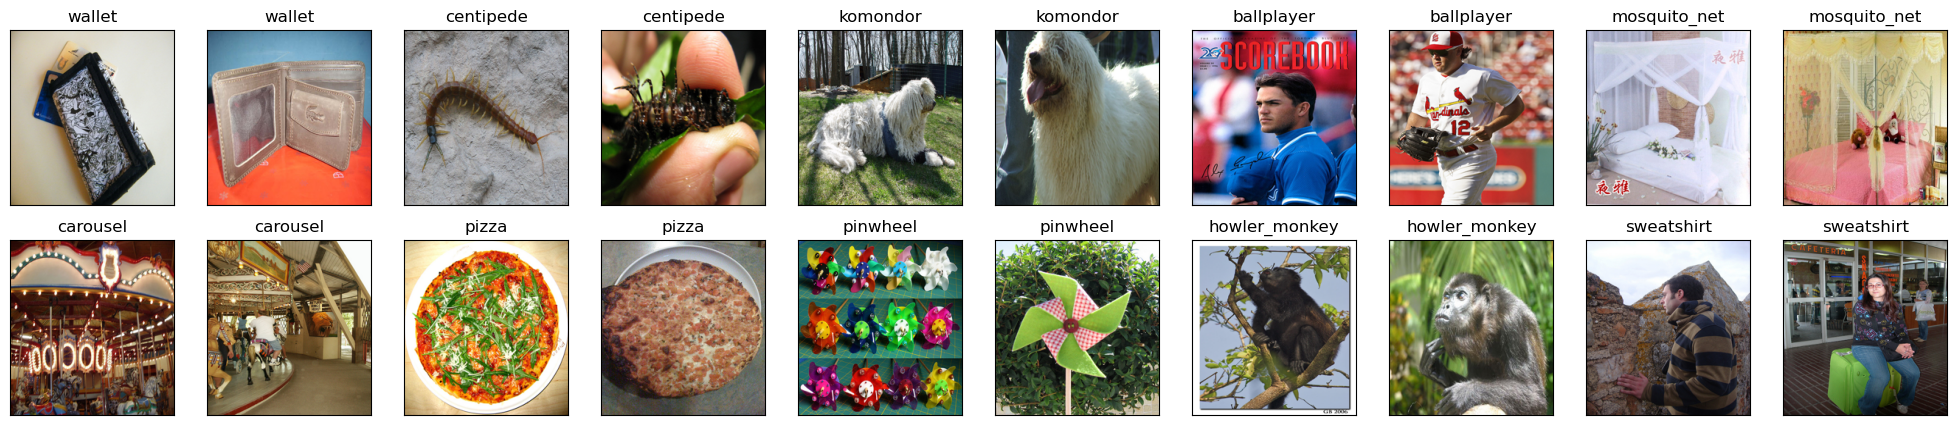

In [9]:
def display_images(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)

    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    titles = np.array([[key] * len(val) for key,val in imgs_dct.items()]).flatten()
    for ax,img,title in zip(axs.flatten(),np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3),titles):
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(title)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
display_images(result)

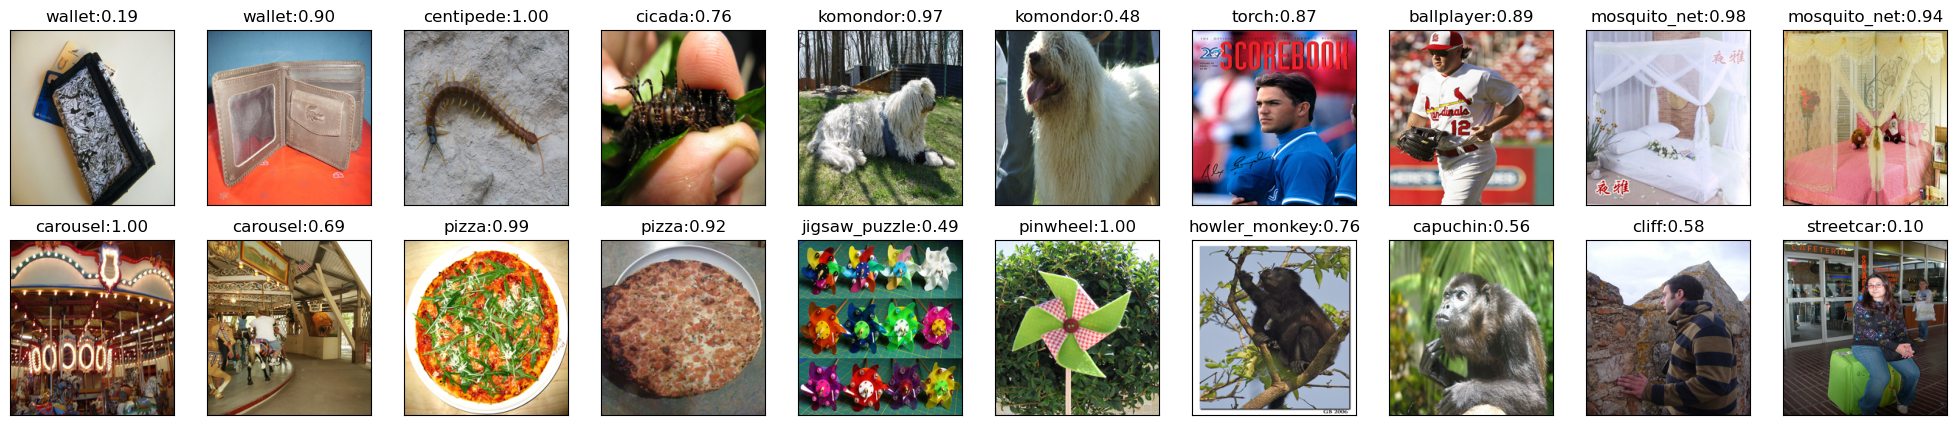

In [10]:
def display_images_with_prediction(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)
    imgs = np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    ready_images = np.array([preprocess_input(x) for x in imgs])
    # return ready_images
    preds = vgg(ready_images).numpy()
    preds = decode_predictions(preds)
    num_cols = int(np.ceil(float(len(imgs)/num_rows)))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,img,pred in zip(axs.flatten(),imgs,preds):
        ttl = pred[0][1]
        prob = round(pred[0][2],ndigits=2)
        
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{ttl}:{prob:0.2f}')
    # plt.subplots_adjust(wspace=0.2, hspace=3)

tmp = display_images_with_prediction(result)

In [14]:
example_images_dict = get_example_images(directory_path='ImageNet-Mini/images',num_classes=np.inf)

Classes Chosen: ['n03527444' 'n04254120' 'n02110341' 'n03933933' 'n01753488' 'n03690938'
 'n12267677' 'n04592741' 'n04136333' 'n02483708' 'n03250847' 'n03485407'
 'n03393912' 'n01692333' 'n01828970' 'n04418357' 'n02749479' 'n03874599'
 'n01491361' 'n03337140' 'n03868242' 'n02690373' 'n01641577' 'n02114367'
 'n02841315' 'n01818515' 'n01608432' 'n02102973' 'n02727426' 'n02102318'
 'n02730930' 'n02105855' 'n03825788' 'n01694178' 'n02091635' 'n03180011'
 'n11879895' 'n03903868' 'n02948072' 'n04081281' 'n04154565' 'n04204347'
 'n04447861' 'n02114548' 'n04613696' 'n04399382' 'n02112350' 'n04146614'
 'n13054560' 'n03992509' 'n09472597' 'n03642806' 'n03930630' 'n07860988'
 'n01689811' 'n03781244' 'n03160309' 'n04606251' 'n02808304' 'n01984695'
 'n03924679' 'n03188531' 'n02110063' 'n04037443' 'n03492542' 'n07693725'
 'n02797295' 'n01728920' 'n04456115' 'n02033041' 'n02097658' 'n02672831'
 'n03733131' 'n03980874' 'n07716906' 'n02088238' 'n03763968' 'n02116738'
 'n04286575' 'n03494278' 'n03944341

# Modeling

In [11]:
# model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)

# # set VGG to be frozen
# for layer in model.layers:
#     layer.trainable = False

# # Selecting a layer and channel to visualize
# layer_name = 'block5_conv2'
# filter_index = 0

# # Isolate the output of interest and create new model
# layer_output = model.get_layer(layer_name).output
# new_model = models.Model(inputs=model.input, outputs=layer_output)
# # now "new_model" has the output we desire to maximize

# # create a variable that we can access and update in computation graph
# I = tf.Variable(np.zeros((1, 150, 150, 3),dtype='double'), name='image_var', dtype = 'float64')

# # now use gradient tape to get the gradients (watching only the variable v)
# with tf.GradientTape(watch_accessed_variables=False) as tape:
#     tape.watch(I) # watch
#     model_vals = new_model(preprocess_input(I)) # get output
#     filter_output_to_maximize = tf.reduce_mean(model_vals[:, :, :, filter_index]) # define what we want to maximize
    
# grad_fn = tape.gradient(filter_output_to_maximize, I) # get gradients that influence loss w.r.t. v
# grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm (better stability)

# # now show the gradient, same size as input image
# plt.imshow(prepare_image_for_display( grad_fn.numpy(), norm_type='std'))
# plt.title('The gradient of filter w.r.t I, $ \sum\partial f_n(I)_{i,j} $ ')
# plt.show()

In [12]:
def generate_pattern(layer_name, filter_index, size=150,epochs=40,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)):
    
    # set VGG to be frozen
    for layer in model.layers:
        layer.trainable = False
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

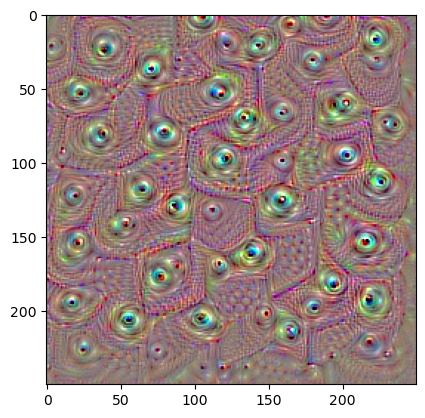

In [13]:
plt.imshow(generate_pattern('block5_conv2', 63, size=250,epochs=40))
plt.show()